<a href="https://colab.research.google.com/github/manirajanvn/KNN/blob/master/pneumonia_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!unzip /content/drive/My\ Drive/ChestXray/chest_xray.zip

Archive:  /content/drive/My Drive/ChestXray/chest_xray.zip
   creating: chest_xray/
  inflating: chest_xray/.DS_Store    
   creating: __MACOSX/
   creating: __MACOSX/chest_xray/
  inflating: __MACOSX/chest_xray/._.DS_Store  
   creating: chest_xray/test/
  inflating: chest_xray/test/.DS_Store  
   creating: __MACOSX/chest_xray/test/
  inflating: __MACOSX/chest_xray/test/._.DS_Store  
   creating: chest_xray/test/PNEUMONIA/
  inflating: chest_xray/test/PNEUMONIA/person147_bacteria_706.jpeg  
   creating: __MACOSX/chest_xray/test/PNEUMONIA/
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person147_bacteria_706.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person100_bacteria_482.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person100_bacteria_482.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person78_bacteria_382.jpeg  
  inflating: __MACOSX/chest_xray/test/PNEUMONIA/._person78_bacteria_382.jpeg  
  inflating: chest_xray/test/PNEUMONIA/person124_bacteria_589.jpeg  
  inflati

In [0]:
import matplotlib.pyplot as plt
import tensorflow.keras as tfk
import numpy as np
import pandas as pd
import skimage
import os
import cv2
import tqdm

In [0]:
TRAIN_PATH = "chest_xray/train/"
VALIDATION_PATH = "chest_xray/val/"
TEST_PATH = "chest_xray/test/"
DISPLAY_P_SAMPLES = "chest_xray/train/PNEUMONIA/"
DISPLAY_N_SAMPLES = "chest_xray/train/NORMAL/"

In [0]:
def extract_data(path_directory):
    X = []
    y = []
    for nextdirectory in os.listdir(path_directory):
        if not nextdirectory.startswith('.'):
            if nextdirectory in ['NORMAL']:
                label = 0
            elif nextdirectory in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = path_directory + nextdirectory
                
            for file in tqdm.tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [6]:
X_train, y_train = extract_data(TRAIN_PATH)

100%|██████████| 1342/1342 [10:38<00:00,  1.81it/s]


In [7]:
X_test, y_test = extract_data(TEST_PATH)

100%|██████████| 234/234 [02:09<00:00,  1.54it/s]


In [0]:
import tensorflow
from tensorflow.keras.utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

In [0]:
savepath="/content/pneumonia_inceptionv3_weights.hdf5"
checkpoint = ModelCheckpoint(savepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [0]:
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Activation
from tensorflow.keras.layers import Dropout , GlobalAveragePooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD , RMSprop , Adadelta , Adam
from tensorflow.keras.layers import Conv2D , BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras import backend as K
K.set_image_data_format('channels_first')
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [0]:
X_train=X_train.reshape(5216,3,150,150)
X_test=X_test.reshape(624,3,150,150)

In [13]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False , input_shape=(3, 150, 150))

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [0]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

In [0]:
base_model.load_weights("/content/inception_v3_weights.h5")

In [0]:
model = Model(inputs=base_model.input, outputs=predictions)

In [0]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', metrics=['accuracy'])

In [0]:
batch_size = 256
epochs = 6

In [21]:

history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[lr_reduce,checkpoint] ,epochs=epochs)

Train on 5216 samples, validate on 624 samples
Epoch 1/6
5184/5216 [============================>.] - ETA: 0s - loss: 0.1328 - acc: 0.9522
Epoch 00001: val_acc improved from -inf to 0.77724, saving model to /content/pneumonia_inceptionv3_weights.hdf5
5216/5216 [==============================] - 97s 19ms/sample - loss: 0.1326 - acc: 0.9525 - val_loss: 1.0721 - val_acc: 0.7772
Epoch 2/6
5184/5216 [============================>.] - ETA: 0s - loss: 0.0822 - acc: 0.9738
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00002: val_acc did not improve from 0.77724
5216/5216 [==============================] - 55s 11ms/sample - loss: 0.0823 - acc: 0.9737 - val_loss: 0.8826 - val_acc: 0.7500
Epoch 3/6
5184/5216 [============================>.] - ETA: 0s - loss: 0.0386 - acc: 0.9875
Epoch 00003: val_acc improved from 0.77724 to 0.79487, saving model to /content/pneumonia_inceptionv3_weights.hdf5
5216/5216 [==============================] - 56s 11ms/sample - l

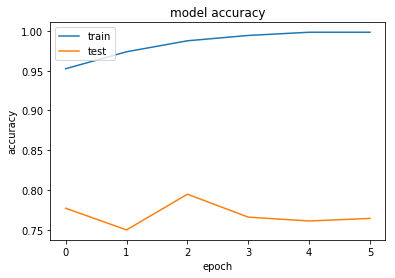

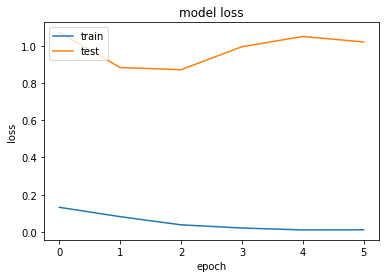

In [22]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

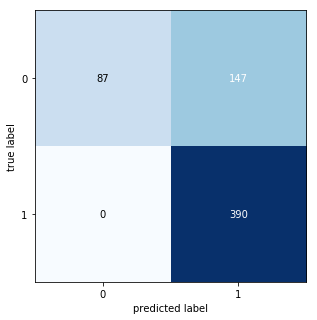

In [24]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

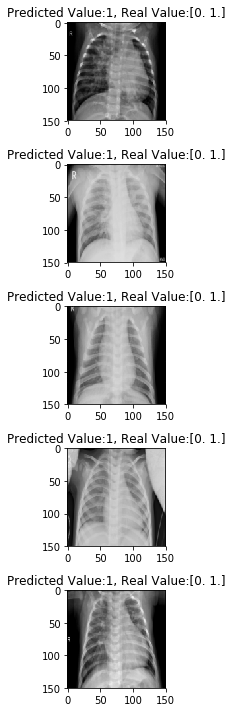

In [25]:
PREDICTION_PATH = 'chest_xray/test/'
fig = plt.figure(figsize=(10,10))
for im, lab, num in zip(X_test[:5], y_test[:5], range(len(X_test[:5]))):
    ax = fig.add_subplot(5,1,num+1)
    ax.imshow(im.reshape(150,150,3))
    ax.set_title(f'Predicted Value:{pred[num]}, Real Value:{lab}')

plt.tight_layout()
plt.show()